In [1]:
import torch
import gpytorch as gp

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import yfinance as yf
import pandas_datareader.data as web

from typing import Tuple

import datetime

from tqdm import tqdm

from utility import get_closing_price_from_yfinance, get_effr_from_nyfed, get_daily_excess_return

In [2]:
class ExactGPModel(gp.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gp.means.ConstantMean()
        self.covar_module = gp.kernels.ScaleKernel(gp.kernels.RBFKernel())
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gp.distributions.MultivariateNormal(mean_x, covar_x)

[*********************100%***********************]  1 of 1 completed


''

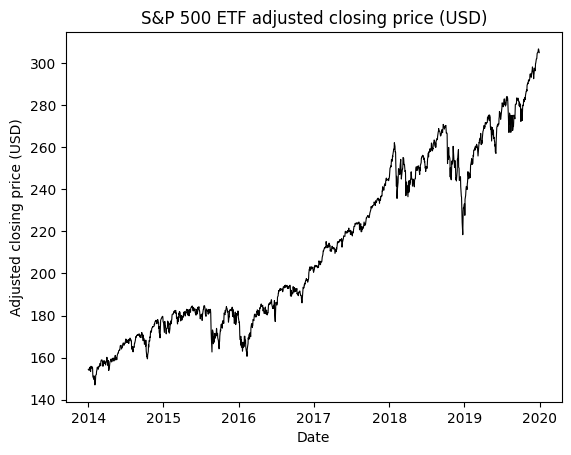

In [3]:
# download data
ticker_symbol = 'SPY'
start_date = datetime.datetime(2014, 1, 1)
end_date = datetime.datetime(2019, 12, 31)

sp_500_etf_close = get_closing_price_from_yfinance(ticker_symbol, start_date, end_date)

# plot data
plt.plot(sp_500_etf_close, color='black', lw =.8)

plt.title('S&P 500 ETF adjusted closing price (USD)')
plt.xlabel('Date')
plt.ylabel('Adjusted closing price (USD)')
;

''

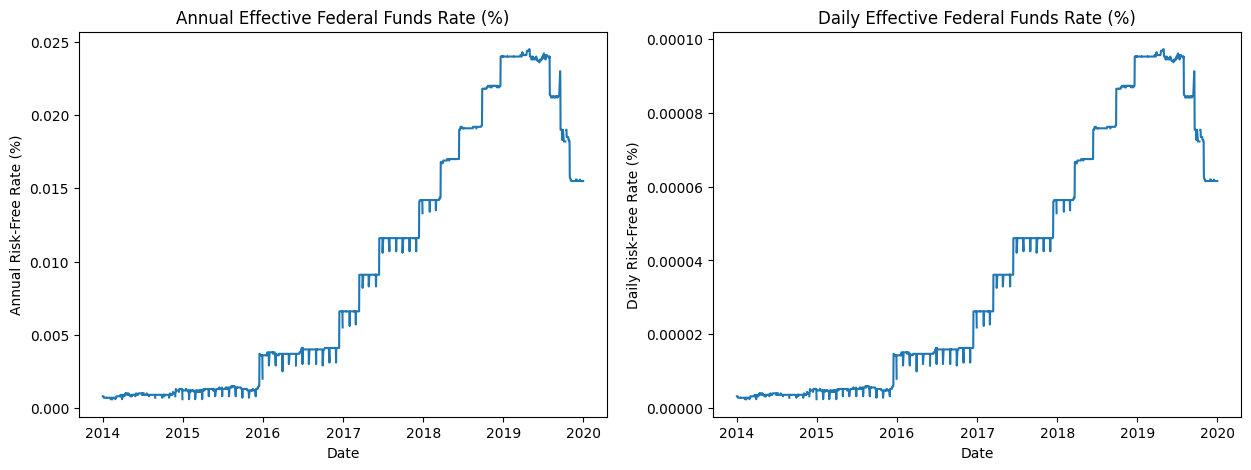

In [4]:
# get data
start_date = datetime.datetime(2014, 1, 1)
end_date = datetime.datetime(2019, 12, 31)

annual_effr = get_effr_from_nyfed(start_date, end_date, daily=False)
daily_effr = get_effr_from_nyfed(start_date, end_date, daily=True)

# plot data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# annual EFFR
ax1.plot(annual_effr)
ax1.set_title('Annual Effective Federal Funds Rate (%)')
ax1.set_xlabel('Date')
ax1.set_ylabel('Annual Risk-Free Rate (%)')

# daily EFFR
ax2.plot(daily_effr)
ax2.set_title('Daily Effective Federal Funds Rate (%)')
ax2.set_xlabel('Date')
ax2.set_ylabel('Daily Risk-Free Rate (%)')
;

Text(0, 0.5, 'Daily Excess Returns (%)')

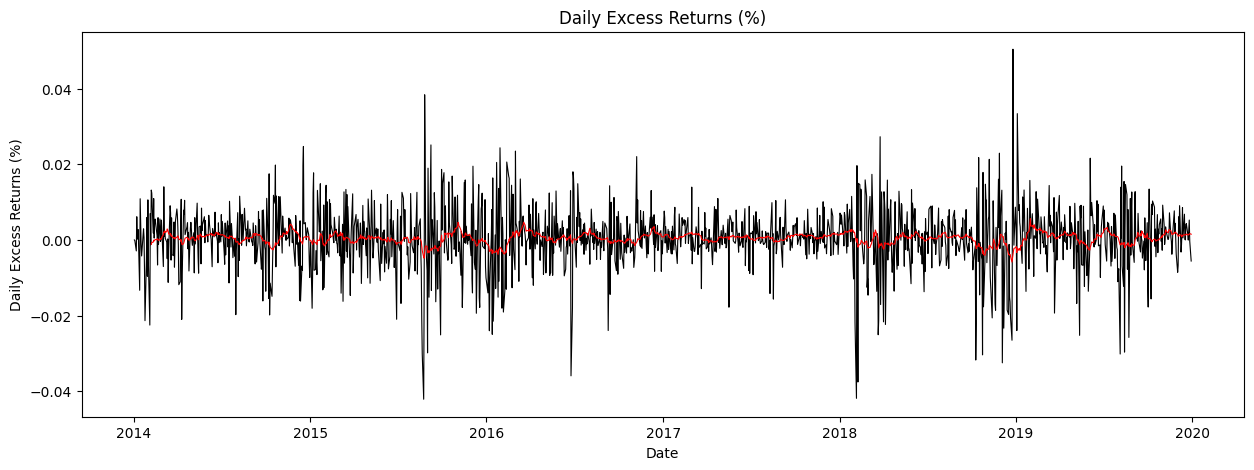

In [105]:
# get data
daily_excess_return = get_daily_excess_return(sp_500_etf_close, daily_effr)

# plot data
plt.figure(figsize=(15, 5))

plt.plot(daily_excess_return['daily_excess_returns'], color='black', lw =.8)

# plot moving average
plt.plot(daily_excess_return['moving_average'], color='red', lw =.8)

plt.title('Daily Excess Returns (%)')
plt.xlabel('Date')
plt.ylabel('Daily Excess Returns (%)')

In [9]:
y_data = daily_excess_return['daily_excess_returns'].values

In [29]:
daily_excess_return

,Adj Close,daily_effr,daily_returns,daily_excess_returns
2014-01-02,154.400284,0.000003,0.000000,0.000000
2014-01-03,154.374908,0.000003,-0.000164,-0.000168
2014-01-06,153.927567,0.000003,-0.002898,-0.002901
2014-01-07,154.872986,0.000003,0.006142,0.006139
2014-01-08,154.906708,0.000003,0.000218,0.000215
...,...,...,...,...
2019-12-23,305.051208,0.000062,0.001528,0.001466
2019-12-24,305.060730,0.000062,0.000031,-0.000030
2019-12-26,306.684601,0.000062,0.005323,0.005262
2019-12-27,306.608612,0.000062,-0.000248,-0.000309


In [10]:
def normalise_data(data):
    """
    Normalise data to zero mean and unit variance.
    
    Arguments:
    ----------
    data        : {np.ndarray}
                    > Data to be normalised.
    
    Returns:
    --------
    norm_data   : {np.ndarray}
                    > Normalised data.
    """
    norm_data = (data - np.mean(data)) / np.std(data)
    return norm_data

In [11]:
y_data_norm = normalise_data(y_data)

Text(0, 0.5, 'Normalised Daily Excess Returns (%)')

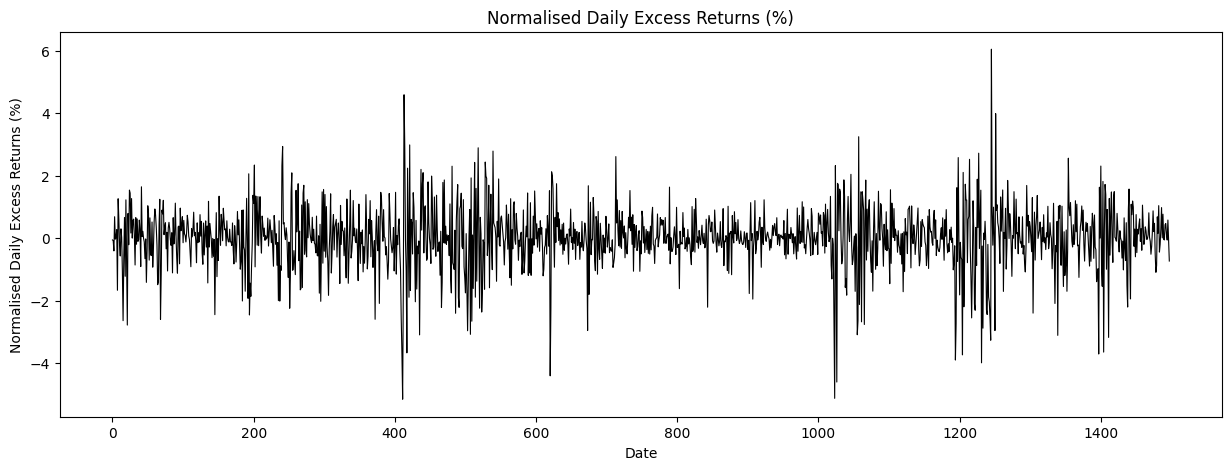

In [12]:
plt.figure(figsize=(15,5))

plt.plot(y_data_norm, color = 'black', lw =.8)

plt.title('Normalised Daily Excess Returns (%)')
plt.xlabel('Date')
plt.ylabel('Normalised Daily Excess Returns (%)')

In [13]:
def get_gp(
        x_train : torch.Tensor, 
        y_train : torch.Tensor,
        ) -> gp.models.ExactGP:
    """
    Consturcts a GP model with Gaussian likelihood

    Arguments:
    ----------
    x_train     : {np.ndarray}
                    > x training data to condition on.
    y_train     : {np.ndarray}
                    > y training data to condition on.
    
    Returns:
    --------
    gp_model   : {gpytorch.models.ExactGP}
                    > GP model.
    """
    # define the likelihood
    likelihood = gp.likelihoods.GaussianLikelihood()

    # instantiate model
    model = ExactGPModel(x_train, y_train, likelihood)

    # update lengthscale and noise
    model.covar_module.base_kernel.lengthscale = torch.tensor(2.5)
    model.likelihood.noise = torch.tensor(0.5)

    return model

In [14]:
# convert data to tensors
y_train = torch.from_numpy(y_data_norm).float()
x_train = torch.arange(start=0, end = len(y_train)).float()

In [15]:
# get model
model = get_gp(x_train, y_train)

In [16]:
# define x_test
N = len(y_train)
gp_range = torch.linspace(0, N, N*3)

x_range = torch.cat((gp_range, x_train))
x_range = torch.unique(x_range)

In [17]:
# get posterior
model.eval()
with torch.no_grad(), gp.settings.fast_pred_var():
    f_preds = model(x_range)

In [18]:
train_threshold = 1400
x_range_mask = x_range > train_threshold

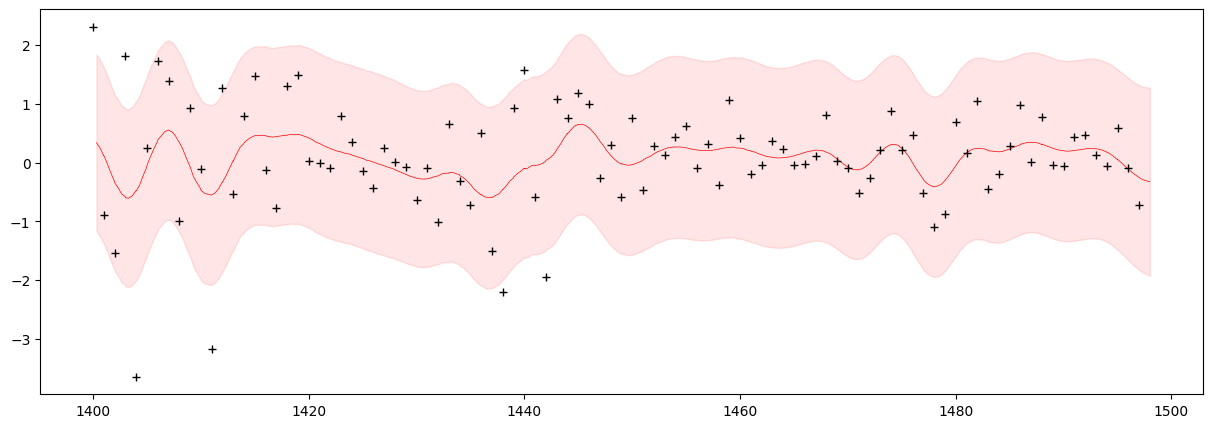

In [19]:
plt.figure(figsize=(15, 5))

plt.plot(x_range[x_range_mask], f_preds.mean[x_range_mask], label='GP mean', color='red', lw=0.5)

# train data
plt.plot(x_train[train_threshold:], y_train[train_threshold:], '+', label='Training data', color='black')

# for i in range(50):
#       f_samples = f_preds.rsample()
#       plt.plot(x_range, f_samples, lw=.25, alpha=.25, color='red')

upper, lower = f_preds.confidence_region()

plt.fill_between(x_range[x_range_mask], lower[x_range_mask], upper[x_range_mask], alpha=0.1, color='red')

#plt.plot(x_train, y_train, color = 'black', lw = 1, alpha = 0.5)

# plt.scatter(x_test, y_test, marker='+', label='Test data', alpha = 1, color='blue', lw=.5)
# plt.plot(x_test, y_test, alpha = 0.5, color='blue')

# Strategy 1 : only GP mean

In [49]:
# get series
P  = daily_excess_return['Adj Close'].values
N = len(P)

# define portolio and cash
V = np.zeros(N)
cash = np.zeros(N)
cash[0] = 1

In [50]:
# setup
N = len(y_train)
gp_range = torch.linspace(0, N, N*3)
x_range = torch.cat((gp_range, x_train))
x_range = torch.unique(x_range)

# sort data
x_range, idx = torch.sort(x_range)

In [51]:
n_long = 0
n_short = 0

for idx, _ in tqdm(enumerate(y_train[:-1])):

    p_eval = P[idx]
    
    # no observations - > do nothing
    if idx == 0:
        V[idx+1] = V[idx]
        cash[idx+1] = cash[idx]
        continue

    # get the current evaluation point
    x_eval = x_train[idx]
    y_eval = y_train[idx]

    # get index in x_range
    x_range_idx = np.where(x_range == x_eval)[0].item()

    # condition on point
    obs_y = y_train[:idx+1]
    obs_x = x_train[:idx+1]
    gaussian_process = get_gp(obs_x, obs_y)

    # get posterior
    model.eval()
    with torch.no_grad(), gp.settings.fast_pred_var():
        f_preds = model(x_range)

    # get the gp mean
    gp_mean = f_preds.mean
    gp_upper, gp_lower = f_preds.confidence_region()

    # print(f"gp_mean: {gp_mean[x_range_idx]:^10.3f} | y_eval: {y_eval:^10.3f} | idx: {idx} | p: {p:^10.3f} | cash: {cash[idx]} | V: {V[idx]}")

    # if (gp_lower[x_range_idx] <= y_eval) and (y_eval <= gp_upper[x_range_idx]):
    #         V[idx+1] = V[idx]
    #         cash[idx+1] = cash[idx]

    if y_eval == gp_mean[x_range_idx]:  
        V[idx+1] = V[idx]
        cash[idx+1] = cash[idx]

    if y_eval > gp_mean[x_range_idx]:
        n_short += 1
        cash[idx+1] = V[idx]*p_eval + cash[idx]
        V[idx+1] = 0
        

    if y_eval < gp_mean[x_range_idx]:
        n_long += 1
        V[idx+1] = cash[idx]/p_eval  + V[idx]
        cash[idx+1] = 0

    if cash[idx] ==0 and V[idx] == 0:
        print('damn')
        print('idx: ', idx)
        print('y_eval: ', y_eval)
        print('gp_mean: ', gp_mean[x_range_idx])
        print('gp_upper: ', gp_upper[x_range_idx])
        print('gp_lower: ', gp_lower[x_range_idx])
        

1497it [00:54, 27.35it/s]


In [54]:
portfolio_value_gp = V*P + cash

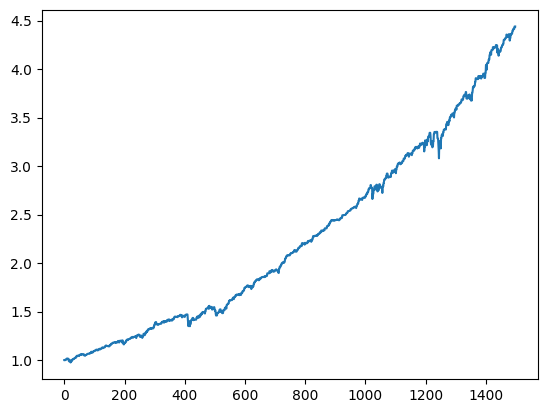

In [56]:
plt.plot(portfolio_value_gp)

In [74]:
# define portolio and cash
V = np.zeros(N)
cash = np.zeros(N)
cash[0] = 1

mu = torch.mean(y_train[:-1])


for idx, _ in tqdm(enumerate(y_train[:-1])):

    p_eval = P[idx]
    
    # no observations - > do nothing
    if idx == 0:
        V[idx+1] = V[idx]
        cash[idx+1] = cash[idx]
        continue

    # get the current evaluation point
    x_eval = x_train[idx]
    y_eval = y_train[idx]

    if y_eval == mu.item():  
        V[idx+1] = V[idx]
        cash[idx+1] = cash[idx]

    if y_eval > mu.item():
        n_short += 1
        cash[idx+1] = V[idx]*p_eval + cash[idx]
        V[idx+1] = 0
        

    if y_eval < mu.item():
        n_long += 1
        V[idx+1] = cash[idx]/p_eval  + V[idx]
        cash[idx+1] = 0

    if cash[idx] ==0 and V[idx] == 0:
        print('damn')
        print('idx: ', idx)
        print('y_eval: ', y_eval)
        print('gp_mean: ', gp_mean[x_range_idx])
        print('gp_upper: ', gp_upper[x_range_idx])
        print('gp_lower: ', gp_lower[x_range_idx])

1497it [00:00, 35798.88it/s]


In [75]:
portfolio_value_mu = V*P + cash

In [124]:
# define portolio and cash
V = np.zeros(N)
cash = np.zeros(N)
cash[0] = 1

ma = pd.DataFrame(y_data_norm).rolling(25).mean().values
ma = torch.tensor(ma)

for idx, _ in tqdm(enumerate(y_train[:-1])):

    p_eval = P[idx]
    
    # no observations - > do nothing
    if idx == 0:
        V[idx+1] = V[idx]
        cash[idx+1] = cash[idx]
        continue

    if np.isnan(ma[idx]):
        V[idx+1] = V[idx]
        cash[idx+1] = cash[idx]
        continue

    # get the current evaluation point
    x_eval = x_train[idx]
    y_eval = y_train[idx]

    if y_eval == ma[idx]:  
        V[idx+1] = V[idx]
        cash[idx+1] = cash[idx]

    if y_eval > ma[idx]:
        n_short += 1
        cash[idx+1] = V[idx]*p_eval + cash[idx]
        V[idx+1] = 0
        

    if y_eval < ma[idx]:
        n_long += 1
        V[idx+1] = cash[idx]/p_eval  + V[idx]
        cash[idx+1] = 0

    if cash[idx] ==0 and V[idx] == 0:
        print('damn')
        print('idx: ', idx)
        print('y_eval: ', y_eval)
        print('gp_mean: ', gp_mean[x_range_idx])
        print('gp_upper: ', gp_upper[x_range_idx])
        print('gp_lower: ', gp_lower[x_range_idx])

1497it [00:00, 15722.46it/s]


In [125]:
portfolio_value_ma = V*P + cash

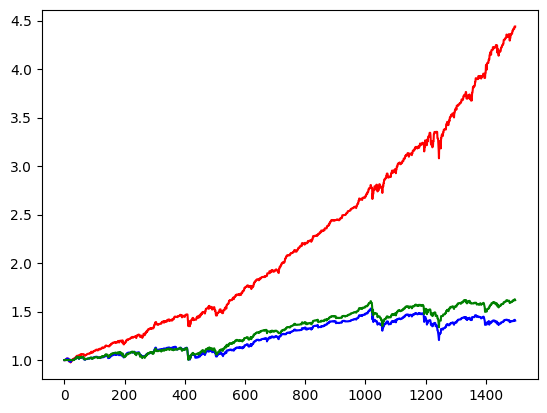

In [126]:

plt.plot(portfolio_value_gp, color = 'red')
plt.plot(portfolio_value_mu, color = 'blue')
plt.plot(portfolio_value_ma, color = 'green')

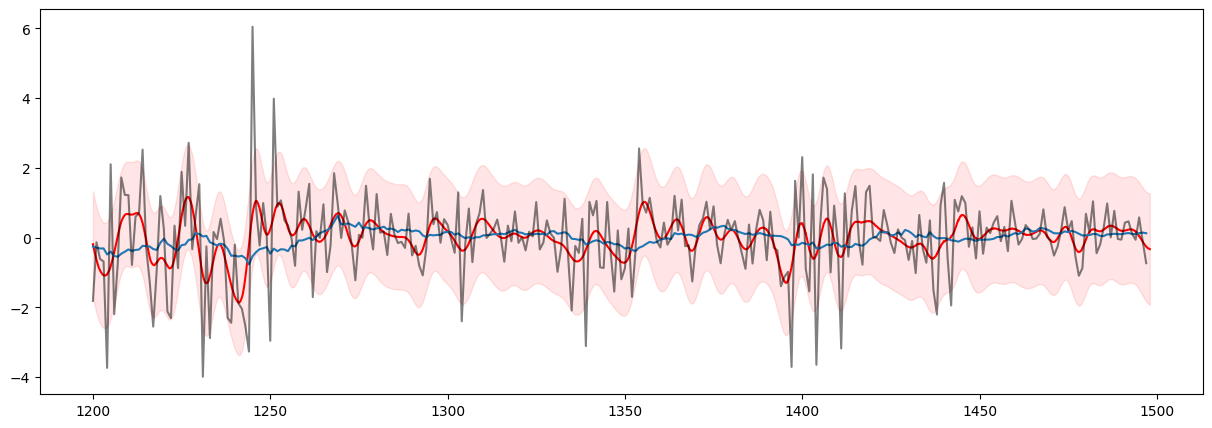

In [144]:
plt.figure(figsize=(15, 5))

x_train_threshold = 1200
range_mask = x_range[x_range >= x_train_threshold]

plt.plot(x_range[x_range >= x_train_threshold], f_preds.mean[x_range >= x_train_threshold], color = 'red')
plt.fill_between(range_mask, f_preds.confidence_region()[0][x_range >= x_train_threshold], f_preds.confidence_region()[1][x_range >= x_train_threshold], alpha = 0.1, color = 'red')
plt.plot(x_train[x_train_threshold:], ma[x_train_threshold:])
plt.plot(x_train[x_train_threshold:], y_train[x_train_threshold:], alpha = 0.5, color = 'black')

In [136]:
n_long = 0
n_short = 0

for idx, _ in tqdm(enumerate(y_train[:-1])):

    p_eval = P[idx]
    
    # no observations - > do nothing
    if idx == 0:
        V[idx+1] = V[idx]
        cash[idx+1] = cash[idx]
        continue

    # get the current evaluation point
    x_eval = x_train[idx]
    y_eval = y_train[idx]

    # get index in x_range
    x_range_idx = np.where(x_range == x_eval)[0].item()

    # condition on point
    obs_y = y_train[:idx+1]
    obs_x = x_train[:idx+1]
    gaussian_process = get_gp(obs_x, obs_y)

    # get posterior
    model.eval()
    with torch.no_grad(), gp.settings.fast_pred_var():
        f_preds = model(x_range)

    # get the gp mean
    gp_mean = f_preds.mean
    gp_upper, gp_lower = f_preds.confidence_region()

    # print(f"gp_mean: {gp_mean[x_range_idx]:^10.3f} | y_eval: {y_eval:^10.3f} | idx: {idx} | p: {p:^10.3f} | cash: {cash[idx]} | V: {V[idx]}")

    if (gp_lower[x_range_idx] <= y_eval) and (y_eval <= gp_upper[x_range_idx]):
            V[idx+1] = V[idx]
            cash[idx+1] = cash[idx]

    if y_eval > gp_upper[x_range_idx]:
        n_short += 1
        cash[idx+1] = V[idx]*p_eval + cash[idx]
        V[idx+1] = 0
        

    if y_eval < gp_lower[x_range_idx]:
        n_long += 1
        V[idx+1] = cash[idx]/p_eval  + V[idx]
        cash[idx+1] = 0

    if cash[idx] ==0 and V[idx] == 0:
        print('damn')
        print('idx: ', idx)
        print('y_eval: ', y_eval)
        print('gp_mean: ', gp_mean[x_range_idx])
        print('gp_upper: ', gp_upper[x_range_idx])
        print('gp_lower: ', gp_lower[x_range_idx])
        

1497it [00:53, 28.22it/s]


In [137]:
portfolio_value_gp_cci = V*P + cash

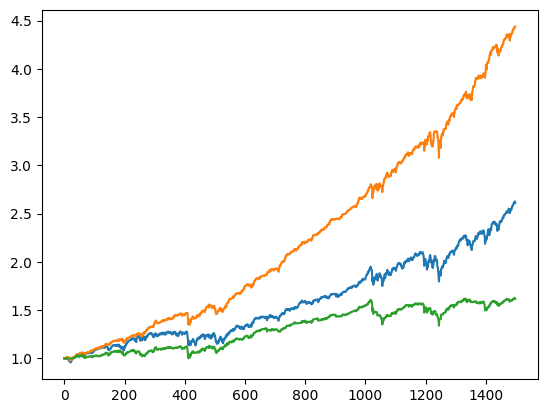

In [140]:
plt.plot(portfolio_value_gp_cci)
plt.plot(portfolio_value_gp)
plt.plot(portfolio_value_ma)